# Defining the Extrema

In [1]:
# imports
from importlib import reload

import numpy as np
from scipy.interpolate import interp1d

import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import seaborn as sns

from siosandbox.cugn import clusters
from siosandbox.cugn import grid_utils
from siosandbox.cugn import io as cugn_io
from siosandbox import plot_utils

from gsw import conversions, density
import gsw

# Load up

In [6]:
line = '90'

# Load
items = cugn_io.load_line(line)
grid_tbl = items['grid_tbl']
ds = items['ds']

# Fill
grid_utils.fill_in_grid(grid_tbl, ds)

In [7]:
grid_tbl.head()

,depth,profile,row,col,doxy,doxy_p,time,lon,z,CT,SA,sigma0,SO,N,chla,T
0,0,32173,17,16,252.912731,88.939052,2016-12-14 19:52:21,-117.460120,10,16.249462,33.523891,24.446819,1.033524,6.383201,0.169041,16.217727
1,0,32174,17,16,252.951126,89.164786,2016-12-14 20:47:19,-117.463420,10,16.214990,33.522302,24.453442,1.032982,5.148775,0.176322,16.183300
2,0,32175,17,17,253.346587,80.334728,2016-12-14 21:38:13,-117.465688,10,16.158025,33.511012,24.457791,1.033375,6.983573,0.252030,16.126182
3,0,32176,17,17,254.551252,86.192469,2016-12-14 22:50:08,-117.471270,10,16.057278,33.502061,24.473762,1.036203,5.451822,0.431141,16.025455
4,0,32177,17,16,251.471860,85.101580,2016-12-15 00:11:51,-117.477442,10,16.372075,33.522704,24.417984,1.030055,5.484878,0.267575,16.340000


## Outliers

In [15]:
perc = 80.
grid_outliers, _, _ = grid_utils.gen_outliers(line, perc)

In [16]:
len(grid_outliers)

191339

# P(DO|S,T) vs SO

In [17]:
grid_outliers.doxy_p.max()

99.9979428947585

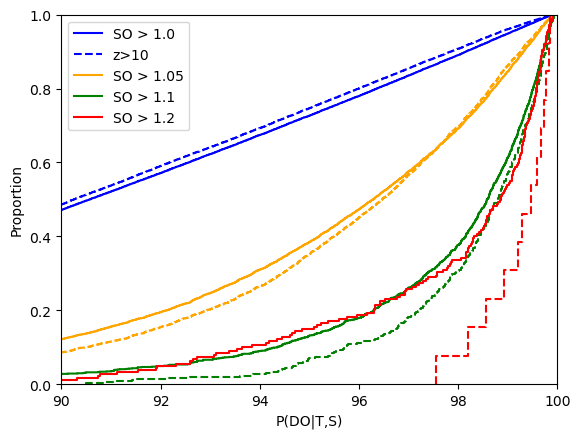

In [24]:
plt.clf()
ax = plt.gca()

# Loop on SO_cut
for clr, SO_cut in zip(['b', 'orange', 'g', 'r'], [1.0, 1.05, 1.1, 1.2]):
    in_cut = grid_outliers.SO > SO_cut
    sns.ecdfplot(x=grid_outliers[in_cut].doxy_p, ax=ax, label=f'SO > {SO_cut}', color=clr)
    in_cut = in_cut & (grid_outliers.z > 10.)
    if SO_cut == 1.0:
        lbl = 'z>10'
    else:
        lbl = None
    sns.ecdfplot(x=grid_outliers[in_cut].doxy_p, ax=ax, linestyle='--', color=clr, label=lbl)

#sns.ecdfplot(x=sogt1_outliers[inshore].N, ax=ax, label='Inshore Clusters')
#sns.ecdfplot(x=sogt1_outliers[inshore & highest].N, ax=ax, label='Inshore Clusters + SO>1')
#sns.ecdfplot(x=sogt1_control, ax=ax, label='Control')
#ax.plot(srt_control[::50], y_cdf[::50], label='Control', color='r')
#ax.plot(srt_shallow_control[::50], y_cdf2[::50], label='Shallow+Inshore Control', color='pink')

#
ax.set_xlabel('P(DO|T,S)')

ax.set_xlim(90., 100)

ax.legend()
plt.show()

# Sub-surface maximum?

In [27]:
ds_SO = ds.SO.data
# Replace nan with 0
isnan = np.isnan(ds_SO)
ds_SO[isnan] = 0.

## Find SO maximum

In [33]:
izmax = np.argmax(ds_SO, axis=0)
ss_max = izmax > 0
np.sum(ss_max)

6692

## Extrema

In [38]:
extrem = grid_outliers.SO > 1.1
grid_extrem = grid_outliers[extrem].copy()
grid_extrem.head()

,depth,profile,row,col,doxy,doxy_p,time,lon,z,CT,SA,sigma0,SO,N,chla,T
782,0,32958,15,18,277.438868,99.488491,2017-03-14 02:17:03,-118.227115,10,15.488374,33.434623,24.549290,1.116404,7.360446,0.285907,15.456250
783,0,32959,15,18,276.052619,98.976982,2017-03-14 03:41:20,-118.217615,10,15.243413,33.434927,24.603163,1.105516,6.704290,0.271055,15.211909
788,0,32964,15,19,298.647665,99.616858,2017-03-14 15:53:33,-118.129770,10,14.946715,33.443485,24.673905,1.189120,7.679979,0.324720,14.916154
789,0,32965,13,19,292.036344,99.696970,2017-03-14 18:54:13,-118.106223,10,14.787911,33.351972,24.638233,1.158375,13.925959,0.397494,14.755500
790,0,32966,13,17,309.040496,99.794239,2017-03-14 21:51:29,-118.080510,10,15.265308,33.331187,24.519477,1.237211,13.226413,0.369575,15.231154


## Number of profiles

In [39]:
uni_prof = np.unique(grid_extrem.profile)
Nprof = uni_prof.size
print(f"There are {Nprof} profiles with an extremum")

There are 1052 profiles with an extremum


## Tag as SSM

In [40]:
grid_extrem['SSM'] = ss_max[grid_extrem.profile]

In [41]:
np.sum(ss_max[uni_prof])

281

## Scatter me

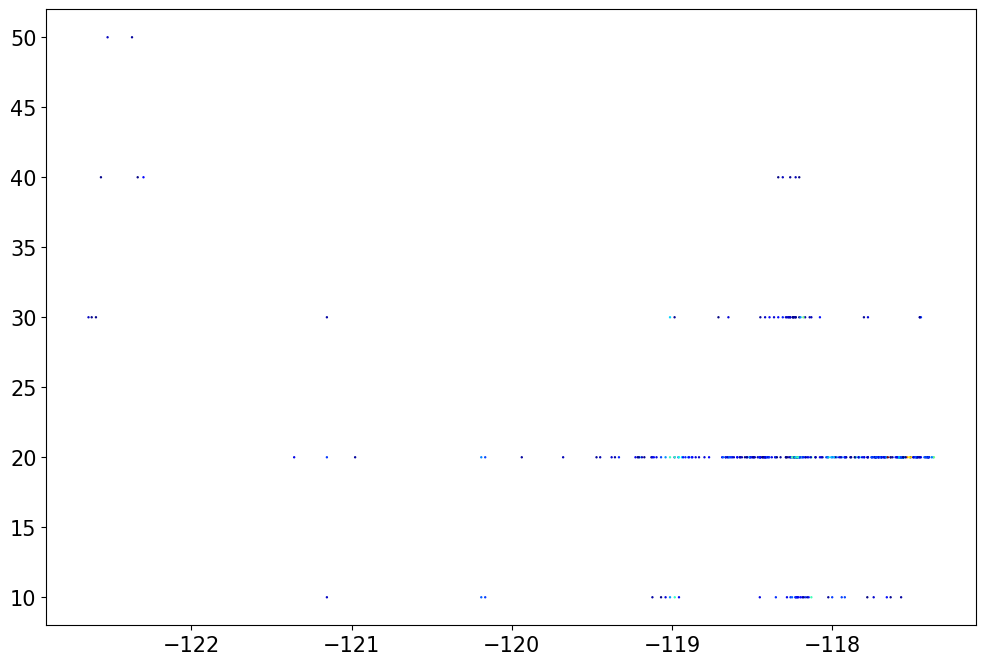

In [42]:
grid = grid_extrem
sval = 0.5

fig = plt.figure(figsize=(12,8))
plt.clf()
ax = plt.gca()

ax.scatter(grid.lon[grid.SSM], grid.z[grid.SSM], s=sval, c=grid.SO[grid.SSM], marker='o', cmap='jet')#, label=f'SO>{sat_lim}')
#ax.scatter(grid.time[~saturated], grid.N[~saturated], s=sval, color='lightgreen', marker='*', label=f'SO < {sat_lim}')

#ax.set_xlim(pandas.Timestamp('2017-01-01'), pandas.Timestamp('2023-08-01'))

#ax.set_ylabel('Buoyancy Frequency')
plot_utils.set_fontsize(ax, 15.)
#ax.legend(fontsize=15., loc='lower right')

#plt.savefig('fig_interannualN.png', dpi=300)

plt.show()

----

# Quick exploration

## DOY

In [62]:
times = pandas.to_datetime(grid_extrem.time.values)
months = times.month
months.max()

11

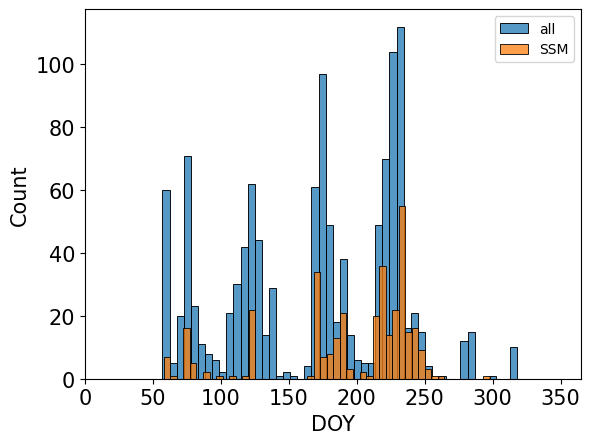

In [60]:
plt.clf()
ax = plt.gca()

sns.histplot(x=times.day_of_year, ax=ax, bins=50, label='all')
#
sns.histplot(x=times[grid_extrem.SSM].day_of_year, ax=ax, bins=50, label='SSM')

ax.set_xlim(0,365.)
ax.set_xlabel('DOY')

plot_utils.set_fontsize(ax, 15.)
ax.legend()

plt.show()

## lon

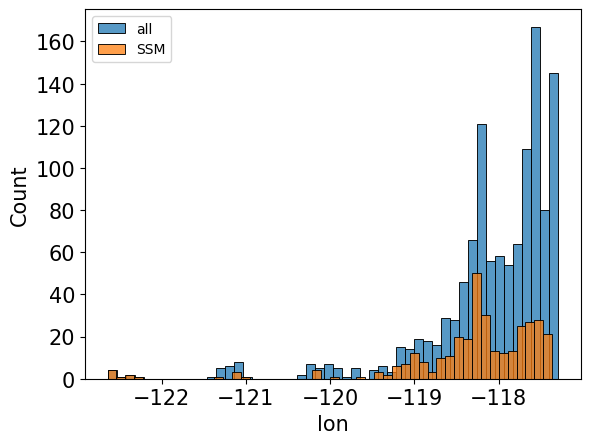

In [64]:
plt.clf()
ax = plt.gca()

sns.histplot(data=grid_extrem, x='lon', ax=ax, bins=50, label='all')
#
sns.histplot(data=grid_extrem[grid_extrem.SSM], x='lon', ax=ax, bins=50, label='SSM')

#ax.set_xlim(0,365.)
#ax.set_xlabel('DOY')

plot_utils.set_fontsize(ax, 15.)
ax.legend()

plt.show()

## $N$

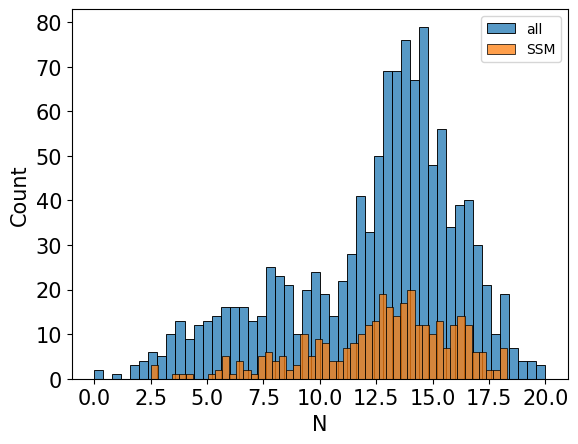

In [65]:
plt.clf()
ax = plt.gca()

sns.histplot(data=grid_extrem, x='N', ax=ax, bins=50, label='all')
#
sns.histplot(data=grid_extrem[grid_extrem.SSM], x='N', ax=ax, bins=50, label='SSM')

#ax.set_xlim(0,365.)
#ax.set_xlabel('DOY')

plot_utils.set_fontsize(ax, 15.)
ax.legend()

plt.show()